[ 1.82314028e-03  1.65062815e-03  1.02941047e-03 -2.22799382e-18
 -1.28269252e-03 -2.57318425e-03 -3.58725017e-03 -4.07129297e-03
 -2.04943315e-03 -1.34049209e-03 -5.67102670e-04  2.22160609e-19
  1.34016495e-04 -2.70656925e-04 -1.14301289e-03 -2.22059175e-03
 -1.26310810e-03 -1.60533615e-03 -1.27458916e-03  1.98327368e-18
  2.29183531e-03  5.39019056e-03  8.76482852e-03  1.16036239e-02
  1.47552138e-02  1.34567318e-02  8.58005201e-03 -9.30757344e-18
 -1.15963700e-02 -2.46507842e-02 -3.68505131e-02 -4.54300709e-02
 -4.94535213e-02 -4.29027222e-02 -2.62415775e-02  1.90159966e-17
  3.33472949e-02  6.94172419e-02  1.02284504e-01  1.25147025e-01
  1.29380515e-01  1.12961545e-01  7.03448475e-02 -2.05849589e-17
 -9.68790487e-02 -2.16412034e-01 -3.52425712e-01 -4.97138523e-01
 -6.40204761e-01 -7.77097030e-01 -8.98934222e-01 -1.00000000e+00
 -1.07651293e+00 -1.12676962e+00 -1.15107480e+00 -1.15151369e+00
 -1.13345457e+00 -1.09772888e+00 -1.05128828e+00 -1.00000000e+00
 -9.49944322e-01 -9.07054

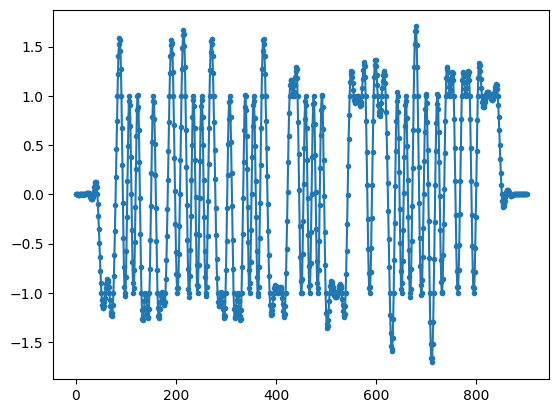

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

# this part came from pulse shaping exercise
num_symbols = 100
sps = 8
bits = np.random.randint(0, 2, num_symbols) # Our data to be transmitted, 1's and 0's
pulse_train = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

# Filter our signal, in order to apply the pulse shaping
samples = np.convolve(pulse_train, h)
print(samples)
plt.figure('before interp')
plt.plot(samples,'.-')

In [15]:
# apply a freq offset
fs = 1e6 # assume our sample rate is 1 MHz
fo = 13000 # simulate freq offset
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
#samples = samples * np.exp(1j*2*np.pi*fo*t) # perform freq shift

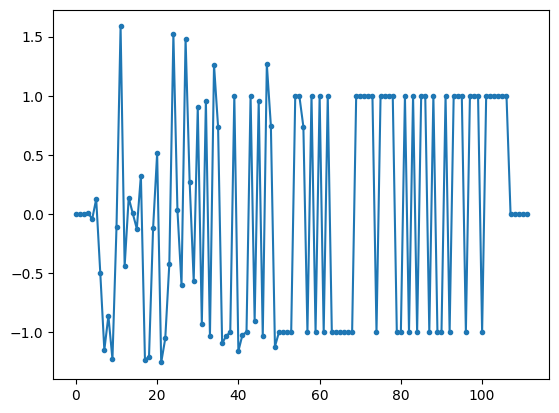

In [11]:
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=complex)
out_rail = np.zeros(len(samples) + 10, dtype=complex) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(samples) and i_in+16 < len(samples):
    out[i_out] = samples[i_in + int(mu)] # grab what we think is the "best" sample
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples = out # only include this line if you want to connect this code snippet with the Costas Loop later on
# Plot the old vs new

plt.figure('after interp')
plt.plot(samples,'.-')
plt.show()

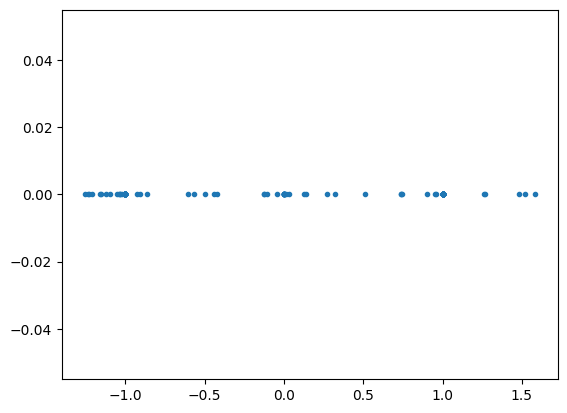

In [12]:
plt.plot(np.real(samples), np.imag(samples), '.')

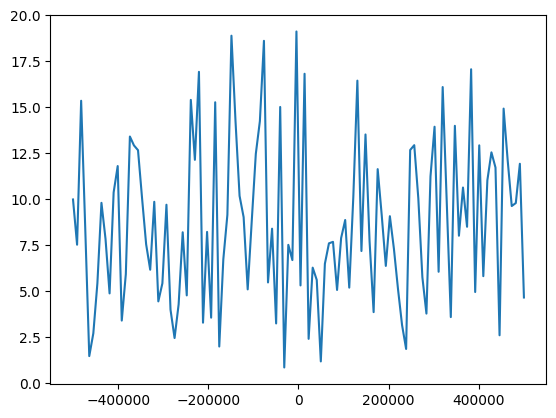

In [24]:
psd = np.fft.fftshift(np.abs(np.fft.fft(samples)))
f = np.linspace(-fs/2.0, fs/2.0, len(psd))
max_freq = f[np.argmax(psd)]
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
samples = samples * np.exp(-1j*2*np.pi*max_freq*t/2.0)
plt.plot(f, psd)
plt.show()

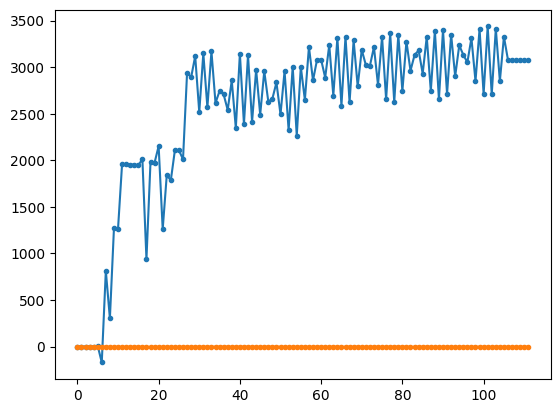

In [22]:
N = len(samples)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
alpha = 0.132
beta = 0.00932
out = np.zeros(N, dtype=complex)
freq_log = []
for i in range(N):
    out[i] = samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * fs / (2*np.pi)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi

# Plot freq over time to see how long it takes to hit the right offset
plt.plot(freq_log,'.-')
plt.show()